In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyhelpme import coast
from src_utils import convert_to_polar, convert_to_polar_pressure_levels, calculate_rmw, plot_coast

plt.rcParams.update({
    "font.size": 16,
    "font.weight": "bold",
    # "font.family": "monospace" 
})

In [2]:
era_sfc_file = '/rtmp/akumar/aurora_ERA/2021-08-28-atmospheric.nc' # get this sample file from https://www.nsstc.uah.edu/data/ankur.kumar/ERA_IDA/2021-08-28-atmospheric.nc
# wget https://www.nsstc.uah.edu/data/ankur.kumar/ERA_IDA/2021-08-28-atmospheric.nc

era_prs = xr.open_dataset(era_sfc_file).isel(valid_time=0)

hurricane_center = {'longitude': -83.3+360, 'latitude': 22.5} 

crop_kwargs = {'longitude': slice(hurricane_center['longitude']-5, hurricane_center['longitude']+5),
              'latitude': slice(hurricane_center['latitude']+5, hurricane_center['latitude']-5)}

era_prs_hurricane = era_prs.sel(**crop_kwargs)

era_prs_hurricane_wind_speed = np.sqrt(era_prs_hurricane['u']**2 + era_prs_hurricane['v']**2)

era_prs_hurricane_wind_speed.coords['hurricane_radial_distance_x'] = era_prs_hurricane_wind_speed.coords['longitude'] - hurricane_center['longitude']
era_prs_hurricane_wind_speed.coords['hurricane_radial_distance_y'] = era_prs_hurricane_wind_speed.coords['latitude'] - hurricane_center['latitude']


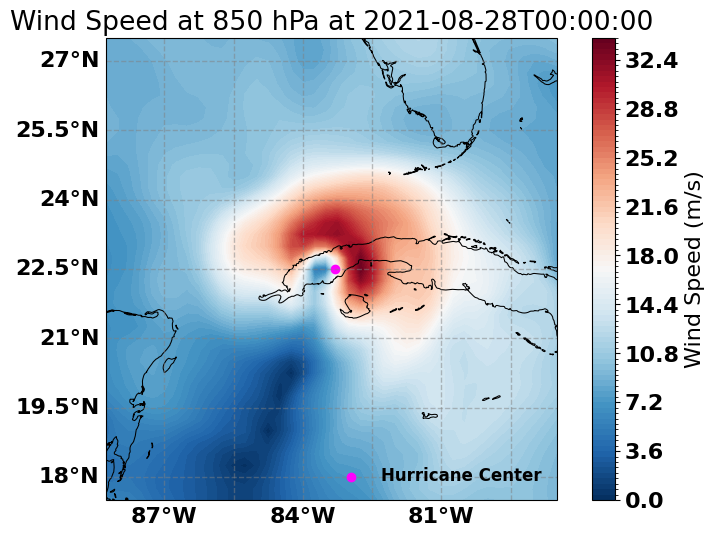

In [7]:
axs = era_prs_hurricane_wind_speed.sel(pressure_level=850).plot.contourf(**coast.get_proj(), figsize=(9, 6), levels=100, cmap='RdBu_r',
                                                                        cbar_kwargs={'label': 'Wind Speed (m/s)'})
plot_coast(axs.axes, linewidth=0.75, states=False)
plt.scatter(hurricane_center['longitude'], hurricane_center['latitude'], color='magenta', label='Hurricane Center')
plt.legend(frameon=False, loc='lower right', fontsize=12)
plt.title(f'Wind Speed at 850 hPa at {era_prs_hurricane_wind_speed.valid_time.values.astype("datetime64[s]").astype(str)}')
plt.savefig('figures/wind_speed_850.png', dpi=400)
plt.show()


For more accurate RMW calculations, consider using the tangential wind speed component.


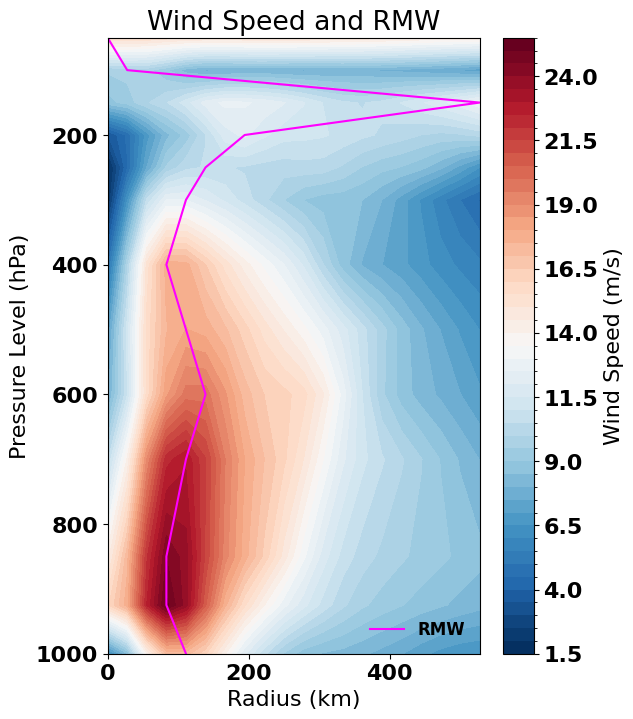

In [8]:
data_polar = convert_to_polar_pressure_levels(era_prs_hurricane_wind_speed, radius=5)

rmw = calculate_rmw(data_polar)

print("Warning: The wind speed used here is the total wind speed magnitude, not the tangential wind speed.")
print("For more accurate RMW calculations, consider using the tangential wind speed component.") 

axs = data_polar.mean(dim='angle').plot.contourf(y='pressure_level', col_wrap=3, figsize=(6, 8), cmap='RdBu_r', levels=50, 
                                                 cbar_kwargs={'label': 'Wind Speed (m/s)'})
axs.axes.plot(rmw.values, rmw.pressure_level, color='magenta', label='RMW')

plt.gca().invert_yaxis()
plt.ylabel('Pressure Level (hPa)')
plt.xlabel('Radius (km)')
plt.legend(frameon=False, loc='lower right', fontsize=12)
plt.title('Wind Speed and RMW')
plt.savefig('figures/wind_speed_RMW.png', dpi=400)
plt.show()
